In [124]:
## Standard imports
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import os
import json
import torch
import astroddpm
import re
import tqdm.notebook as tqdm

## Relative imports
from astroddpm.runners import Diffuser, config_from_id, get_samples
from astroddpm.analysis.validationMetrics import powerSpectrum, minkowskiFunctional, basics
from astroddpm.analysis import overfitting_check
from astroddpm.utils.plot import check_nearest_epoch, plot_losses, check_training_samples, plot_comparaison
from astroddpm.diffusion.dm import DiscreteSBM
from astroddpm.diffusion.stochastic.sde import DiscreteVPSDE
from astroddpm.diffusion.models.network import ResUNet
import astroddpm.utils.colormap_custom 
from quantimpy import minkowski as mk

## Wasserstein distance
from scipy.stats import wasserstein_distance

In [125]:
save_fig = True

params = {'text.usetex': True,
         'text.latex.preamble': r'\usepackage{amsmath}',
         "font.family": "serif", "font.serif": ["Computer Modern Roman"],
         'font.size': 12,
         'image.interpolation': 'none'}
plt.rcParams.update(params)

In [126]:
ALL_MODELS = os.path.join(os.path.dirname(astroddpm.__file__), 'config', 'MODELS.json')

NOISE_LEVEL = 0.8

NUM_SAMPLES = 64
AVG_PS_OF_NOISE = True ## Averages the power spectrum of added_noise on images

with open(ALL_MODELS, 'r') as f:
    ALL_MODELS_DICT = json.load(f)
print(ALL_MODELS_DICT.keys())

dict_keys(['DiscreteSBM_ND_SigmaVPSDE_MHD_BPROJ_N_4000_bottleneck_32', 'DiscreteSBM_ND_SigmaVPSDE_MHD_BPROJ_N_1000_bottleneck_16', 'DiscreteSBM_ND_SigmaVPSDE_MHD_BPROJ_N_4000_bottleneck_16', 'DiscreteSBM_ND_VPSDE_MHD_BPROJ_N_1000_bottleneck_32', 'DiscreteSBM_ND_VPSDE_MHD_BPROJ_N_1000_bottleneck_16', 'DiscreteSBM_ND_SigmaVPSDE_MHD_BPROJ_N_8000_bottleneck_16', 'DiscreteSBM_ND_VPSDE_MHD_BPROJ_N_4000_bottleneck_32', 'DiscreteSBM_ND_SigmaVPSDE_MHD_BPROJ_N_8000_bottleneck_32', 'DiscreteSBM_ND_VPSDE_MHD_BPROJ_N_4000_bottleneck_16', 'DiscreteSBM_ND_VPSDE_MHD_BPROJ_N_8000_bottleneck_32', 'DiscreteSBM_ND_VPSDE_MHD_BPROJ_N_8000_bottleneck_16', 'DiscreteSBM_ND_SigmaVPSDE_MHD_BPROJ_N_1000_bottleneck_32', 'DiscreteSBM_ND_SigmaVPSDE_MHD_BPROJ_N_4000_bottleneck_32_betamin_0.01_step', 'DiscreteSBM_ND_SigmaVPSDE_MHD_BPROJ_N_4000_bottleneck_32_betamin_0.05_invsqrt', 'DiscreteSBM_ND_SigmaVPSDE_MHD_BPROJ_N_1000_bottleneck_16_betamin_0.05_step', 'DiscreteSBM_ND_SigmaVPSDE_MHD_BPROJ_N_4000_bottleneck_32_beta

In [127]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

MODEL_ID_1 = 'DiscreteSBM_MultiSigmaVPSDE_I_BPROJ_N_1000_bottleneck_16_firstc_6'
MODEL_ID_2 = 'DiscreteSBM_SigmaVPSDE_I_BPROJ_N_1000_bottleneck_16_firstc_6'

NUM_SAMPLES = 64

In [128]:
placeholder_dm = DiscreteSBM(DiscreteVPSDE(1000), ResUNet())

diffuser_1 = Diffuser(placeholder_dm)
diffuser_1.load(config=config_from_id(MODEL_ID_1), also_ckpt=True, for_training=True)

diffuser_2 = Diffuser(placeholder_dm)
diffuser_2.load(config=config_from_id(MODEL_ID_2), also_ckpt=True, for_training=True)

No model id found
Loading the diffuser from a config dict.
Loading the optimizer and scheduler states from the checkpoint, as well as previous training info. You should change the model id if you want to finetune the model.
No model id found
Loading the diffuser from a config dict.
Loading the optimizer and scheduler states from the checkpoint, as well as previous training info. You should change the model id if you want to finetune the model.


### Comparison in generative mode

In [129]:
theta_mean = torch.tensor([70,0.0321]).to(device).reshape(1,2)
theta_mean

tensor([[7.0000e+01, 3.2100e-02]], device='cuda:0')

In [130]:
gen_1 = diffuser_1.diffmodel.generate_image(NUM_SAMPLES, thetas = theta_mean.repeat(NUM_SAMPLES,1))

  3%|▎         | 31/1000 [00:00<00:25, 38.20it/s]

100%|██████████| 1000/1000 [00:26<00:00, 37.97it/s]


In [131]:
gen_2 = diffuser_2.diffmodel.generate_image(NUM_SAMPLES)

  2%|▏         | 15/1000 [00:00<00:25, 39.19it/s]

100%|██████████| 1000/1000 [00:26<00:00, 37.94it/s]


In [132]:
##
## COMPUTTATION OF THE POWER SPECTRUM
##

max_num_samples = 128

## Get elements of the dataset
dataset = diffuser_1.train_dataloader.dataset
shape = dataset[0].shape
if len(shape) == 3:
    datapoints = torch.cat([dataset[i].reshape(1,-1,shape[1], shape[2]) for i in range(min(len(dataset), max_num_samples))]).to(device)
elif len(shape) == 2:
    datapoints = torch.cat([dataset[i].reshape(1,1,shape[0], shape[1]) for i in range(min(len(dataset), max_num_samples))]).to(device)
else:
    datapoints = torch.cat([dataset[i] for i in range(min(len(dataset), max_num_samples))]).to(device)

## Compute power spectrum
bins = torch.linspace(0, np.pi, 100).to(device)

bins_centers = (bins[:-1] + bins[1:])/2
bins_centers = bins_centers.cpu()
mean_list = []
std_list = []
power_spectra_list = []
for data in [gen_1, gen_2, datapoints]:
    power_spectra_, mean_, std_ , bins = powerSpectrum.set_power_spectrum_iso2d(data.to(device), bins, use_gpu=True, only_stat=False)
    mean_list.append(mean_)
    std_list.append(std_)
    power_spectra_list.append(power_spectra_)

mean_list = [mean.cpu().numpy() for mean in mean_list]
std_list = [std.cpu().numpy() for std in std_list]

In [133]:
ps_bins = bins_centers.cpu()
ps_orig = mean_list[2][:-1]
ps_orig_std = std_list[2][:-1]
ps_multi = mean_list[0][:-1]
ps_multi_std = std_list[0][:-1]
ps_mono = mean_list[1][:-1]
ps_mono_std = std_list[1][:-1]

In [134]:
power_spectra_list[0].shape

torch.Size([64, 100])

In [135]:
wasserstein_mono_to_data = np.zeros((100,))
wasserstein_multi_to_data = np.zeros((100,))

In [136]:
power_spectra_list[0].shape

torch.Size([64, 100])

In [137]:
for i in range(100):
    wasserstein_mono_to_data[i] = wasserstein_distance(torch.log(power_spectra_list[1][:,i]).cpu(), torch.log(power_spectra_list[2][i]).cpu())
    wasserstein_multi_to_data[i] = wasserstein_distance(torch.log(power_spectra_list[0][:,i]).cpu(), torch.log(power_spectra_list[2][i]).cpu())

In [138]:
def running_mean(x, N):
    return np.convolve(x, np.ones((N,))/N, mode='valid')

In [144]:
bins_comp = running_mean(bins.cpu(), 10)

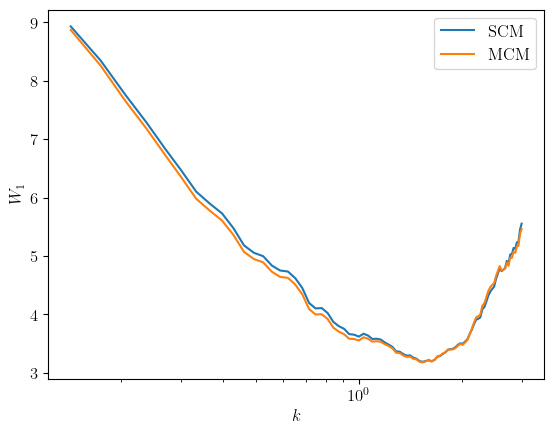

In [145]:
plt.plot(bins_comp,running_mean(wasserstein_mono_to_data,10), label='SCM')
plt.plot(bins_comp,running_mean(wasserstein_multi_to_data,10), label='MCM')
plt.xlabel(r'$k$')
plt.ylabel(r'$W_1$')
plt.xscale('log')
plt.legend()
plt.savefig('figs/wasserstein_SCM_MCM.pdf', bbox_inches='tight')

In [141]:
wasserstein_mono_to_data.mean(), wasserstein_multi_to_data.mean()

(4.65038246758245, 4.611968078064174)

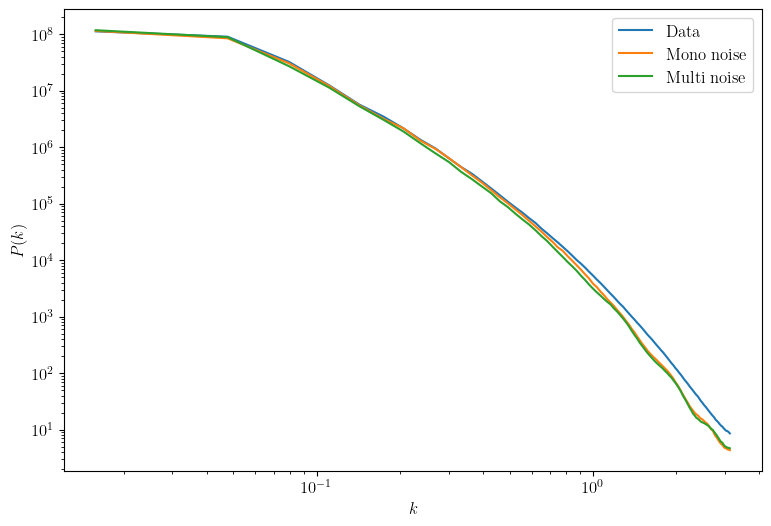

In [142]:
fig, axs = plt.subplots(1, 1, figsize=(9, 6))

axs.plot(ps_bins, ps_orig, label='Data', color='C0')
#axs.fill_between(ps_bins, ps_orig-ps_orig_std, ps_orig+ps_orig_std, alpha=0.5, color='C0')

axs.plot(ps_bins, ps_mono, label='Mono noise', color='C1')
#axs.fill_between(ps_bins, ps_mono-ps_mono_std, ps_mono+ps_mono_std, alpha=0.5, color='C1')

axs.plot(ps_bins, ps_multi, label='Multi noise', color='C2')
#axs.fill_between(ps_bins, ps_multi-ps_multi_std, ps_multi+ps_multi_std, alpha=0.5, color='C2')

axs.set_yscale('log')
axs.set_xscale('log')

axs.set_xlabel(r'$k$')
axs.set_ylabel(r'$P(k)$')

axs.legend()

### Comparison in denoising

### Comparison of robustness or lack thereof